Тк в многоклассовой классификации очень хорошо показал себя xgboost, сразу попробуем применить его.

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
import preprocessing as pre
from models_analysis import plot_validation_curves, get_scores, get_scores_point
from xgboost import XGBClassifier
from cap_project_uid import load_catch_me_data, create_pipeline, FeaturesSelector

In [2]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
train_data, test_data, y_catch_me = load_catch_me_data()

In [4]:
time_split = TimeSeriesSplit(n_splits=5)

In [18]:
bag_of_sites = ['site'+str(i) for i in range(1, 11)]
is_top_feats = ['is_top'+str(i) for i in range(1, 31)]
categorical_feats = ['binned_start_hour', 'day_of_week', 'day']
binary_feats = ['unique_site_1', 'unique_site_2']
numerical_feats = ['unique_sites']

num_preprocessor = FeatureUnion([
    ('woe_encoding', FunctionTransformer(lambda data: pre.woe_encoder(data, 'session_timespan', 
                                        max_lim=100, fill_method='outlier', for_pipeline=True))),
    ('others', FunctionTransformer(lambda data: data.loc[:, numerical_feats]\
                                   .drop('session_timespan', axis=1)))
])

In [20]:
model = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor',
                   use_label_encoder=False, verbosity=0)

In [21]:
pipeline = Pipeline(steps=[
    ('feature_processing', FeatureUnion(transformer_list=[
        ('binary_variables', FunctionTransformer(lambda data: data.loc[:, binary_feats])),
        ('categorical_variables', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, categorical_feats])),
            ('hot_encoding', OneHotEncoder(handle_unknown='ignore'))
            #('dim_reducing', TruncatedSVD(30))
        ])),
        ('bag_of_sites', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, bag_of_sites].apply(lambda row: \
                                                            ' '.join([str(x) for x in row]), axis=1))),
            ('vectorizer', TfidfVectorizer())
        ])),
        ('is_top_site', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, is_top_feats]))
            #('dim_reducing', TruncatedSVD(20))
        ])),
        ('numerical_variables', Pipeline(steps=[
            ('selecting', FunctionTransformer(lambda data: data.loc[:, numerical_feats])),
         #   ('log_preprocessing', num_preprocessor),
            ('scaling', StandardScaler())
        ]))
    ])),
    ('classifier', model)
])

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data, y_catch_me, 
                                                      test_size=0.3, shuffle=False)
data_params = [X_train, X_valid, y_train, y_valid]

In [7]:
xgb_params_cv = {'classifier__reg_alpha': np.arange(200, 351, 15)}

In [60]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params_cv, scoring='precision', n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train)

Wall time: 8min 13s


GridSearchCV(estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x00000218B8F0EEE0>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x00000218B8F0EB80>)),
                                                                                        ('hot_encoding',
                                                                                         OneHotEncoder(handle_unknown='ignore...
                                                      num_parallel_tree=1,
                                     

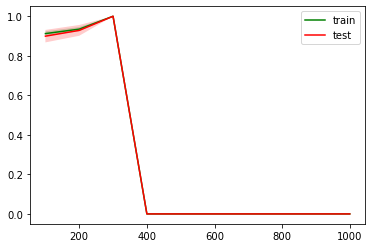

In [58]:
plot_validation_curves(xgb_params_cv['classifier__reg_alpha'],
                       xgb_searcher.cv_results_)

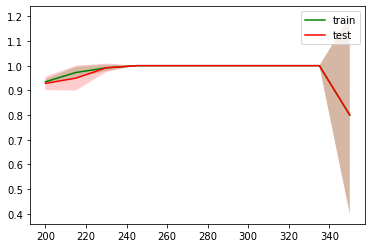

In [61]:
plot_validation_curves(xgb_params_cv['classifier__reg_alpha'],
                       xgb_searcher.cv_results_)

In [63]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000218B8F0EEE0>)),
                                                ('categorical_variables',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000218B8F0EB80>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore')),
                                                                 ('dim_reducing',
                                                                  Tru...
                               interaction_constraints='', learning_rate=0.4,
                               max_delta_step=0, max_depth=7,


In [41]:
get_scores_point(pipeline, 'xgb_n20_d5_nowoe', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
xgb_n20_d5_nowoe,0.994,0.994,0.762,0.985,0.933,0.688


In [23]:
get_scores_point(pipeline, 'xgb_n70_d7', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
xgb_n70_d7,0.996,0.996,0.871,0.995,0.94,0.821


In [24]:
get_scores_point(pipeline, 'xgb_n70_d7_l110', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
xgb_n70_d7_l110,0.995,0.995,0.843,0.995,0.939,0.782


In [31]:
get_scores_point(pipeline, 'xgb_n70_d7_l1100', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
xgb_n70_d7_l1100,0.993,0.993,0.717,0.982,0.934,0.646


In [38]:
get_scores_point(pipeline, 'xgb_n70_d7_l210_l1100', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
xgb_n70_d7_l210_l1100,0.993,0.993,0.717,0.982,0.936,0.646


In [45]:
get_scores_point(pipeline, 'xgb_n70_d7_l21e3_l11e3', *data_params)

c:\programdata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
xgb_n70_d7_l21e3_l11e3,0.991,0.991,0.498,0.938,0.495,0.5


In [64]:
get_scores_point(pipeline, 'xgb_n70_d7_l210_l1260', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
xgb_n70_d7_l210_l1260,0.991,0.991,0.542,0.972,0.928,0.523


#### Попробуем кросс-валидацию с учетом времени (TimeSeriesSplit)

In [6]:
xgb_params = {'classifier__n_estimators': 40,
             'classifier__max_depth': 7,
             'classifier__learning_rate': 0.4}
pipeline.set_params(**xgb_params)

NameError: name 'pipeline' is not defined

In [31]:
xgb_params_cv = {'classifier__n_estimators': np.arange(1, 102, 10)}

In [32]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params_cv, scoring='f1', cv=time_split, n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train)

Wall time: 13min 52s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('binary_variables',
                                                                        FunctionTransformer(func=<function <lambda> at 0x0000017E89805DC0>)),
                                                                       ('categorical_variables',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function <lambda> at 0x0000017E89805D30>)),
                                                                                        (...
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                          

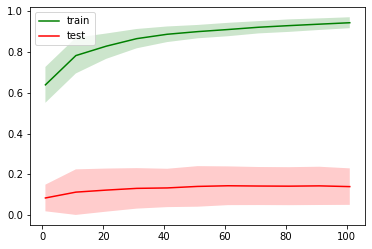

In [33]:
plot_validation_curves(xgb_params_cv['classifier__n_estimators'], xgb_searcher.cv_results_)

При применении такой кросс-валидации xgboost сильно ошибается на тесте. Значит теперь можно отслеживать переобучение.

In [19]:
xgb_params_cv = {'classifier__scale_pos-weight': np.arange(1, 6)}

In [20]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params_cv, scoring='f1', cv=time_split, n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train)

Wall time: 2min 58s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('bag_of_sites',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function create_pipeline.<locals>.<lambda> at 0x0000027EDA48C940>)),
                                                                                        ('vectorizer',
                                                                                         TfidfVectorizer()),
                                                                                        ('feats_counter',
                                                                                         None)])),
                                                                       ('binary_f

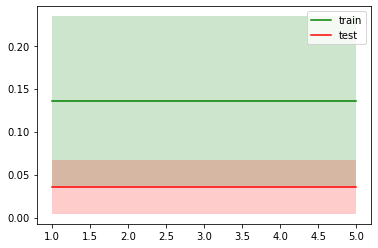

In [21]:
plot_validation_curves(xgb_params_cv['classifier__scale_pos-weight'], xgb_searcher.cv_results_)

## Сравнение моделей

In [25]:
pipeline = create_pipeline(['bag_of_sites'], model=SGDClassifier('log', n_jobs=-1), model_params=xgb_params)

In [46]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('bag_of_sites',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function create_pipeline.<locals>.<lambda> at 0x0000027ECEE65E50>)),
                                                                 ('vectorizer',
                                                                  TfidfVectorizer()),
                                                                 ('feats_counter',
                                                                  None)])),
                                                ('binary_feats',
                                                 FunctionTransformer(func=<function create_pipeline.<locals>.<lambda> at 0...
                               interaction_constraints='', learning_rate=0.4,
                               max_delta_step=0, max_depth=7,


In [28]:
get_scores_point(pipeline, 'sgd_logit', *data_params)

c:\programdata\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
sgd_logit,0.991,0.991,0.498,0.88,0.495,0.5


In [29]:
pipeline = create_pipeline(model=SGDClassifier('log', n_jobs=-1), model_params=xgb_params)

In [31]:
get_scores_point(pipeline, 'pipe_logit', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
pipe_logit,0.989,0.991,0.503,0.937,0.829,0.503


In [39]:
pipeline = create_pipeline(['bag_of_sites'], model=True, model_params=xgb_params)

In [35]:
get_scores_point(pipeline, 'xgb', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
xgb,0.991,0.991,0.498,0.599,0.495,0.5


In [41]:
pipeline.fit(train_data, y_catch_me)
write_to_submission_file(pipeline.predict_proba(test_data)[:, 1], 'xgb_empty.csv')

In [45]:
pipeline = create_pipeline(model=True, model_params=xgb_params)

In [38]:
get_scores_point(pipeline, 'pipe_xgb', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
pipe_xgb,0.967,0.991,0.552,0.95,0.749,0.53


In [47]:
get_scores_point(pipeline, 'pipe_xgb_n70', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
pipe_xgb_n70,0.965,0.991,0.564,0.947,0.733,0.538


In [43]:
pipeline.fit(train_data, y_catch_me)
write_to_submission_file(pipeline.predict_proba(test_data)[:, 1], 'xgb_pipe.csv')

In [48]:
pipeline.fit(train_data, y_catch_me)
write_to_submission_file(pipeline.predict_proba(test_data)[:, 1], 'xgb_pipe_n70.csv')

## xgboost и параметры Tfidf

In [6]:
vectorizer_name = 'feature_processing__bag_of_sites__vectorizer__'
xgb_params = {'n_estimators': 40,
             'max_depth': 7,
             'learning_rate': 0.4
             }

In [8]:
pipeline = create_pipeline(['bag_of_sites'], model=True, model_params=xgb_params)

In [58]:
vectorizer_name = 'feature_processing__bag_of_sites__vectorizer__'
xgb_params_cv = {vectorizer_name + 'ngram_range': [(1, 1), (1, 2), (1, 3)]}

In [52]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params_cv, scoring='roc_auc', cv=time_split, n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train)

Wall time: 9min 48s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('bag_of_sites',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function create_pipeline.<locals>.<lambda> at 0x0000027ED1097F70>)),
                                                                                        ('vectorizer',
                                                                                         TfidfVectorizer()),
                                                                                        ('feats_counter',
                                                                                         None)])),
                                                                       ('binary_f

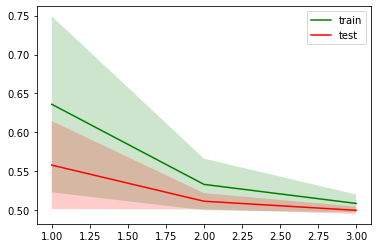

In [53]:
plot_validation_curves([1, 2, 3], xgb_searcher.cv_results_)

Попробуем настраивать параметры при ngram_range (1, 1)

**max_df, ngram_range = (1, 1)**

In [33]:
xgb_params_cv = {vectorizer_name + 'ngram_range': [(1, 1)],
                vectorizer_name + 'max_df': np.linspace(0.01, 0.1, 10)}

In [34]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params_cv, scoring='accuracy', cv=time_split, n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train)

Wall time: 6min 23s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('bag_of_sites',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function create_pipeline.<locals>.<lambda> at 0x0000021DA0AF6EE0>)),
                                                                                        ('vectorizer',
                                                                                         TfidfVectorizer()),
                                                                                        ('feats_counter',
                                                                                         None)])),
                                                                       ('binary_f

**roc_auc**

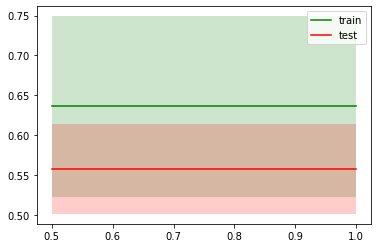

In [56]:
plot_validation_curves(xgb_params_cv[vectorizer_name + 'max_df'], xgb_searcher.cv_results_)

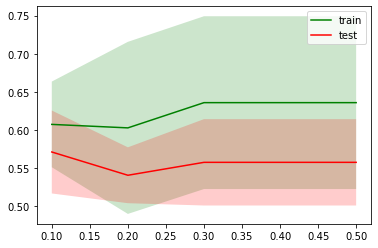

In [59]:
plot_validation_curves(xgb_params_cv[vectorizer_name + 'max_df'], xgb_searcher.cv_results_)

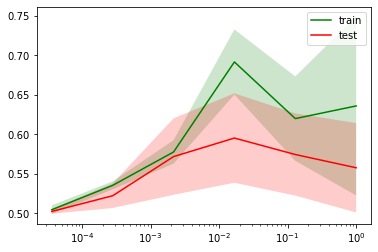

In [26]:
plt.xscale('log')
plot_validation_curves(xgb_params_cv[vectorizer_name + 'max_df'], xgb_searcher.cv_results_)

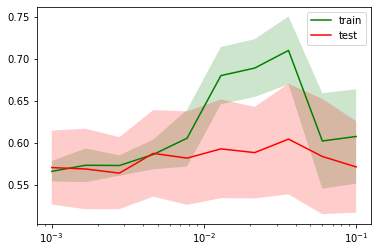

In [29]:
plt.xscale('log')
plot_validation_curves(xgb_params_cv[vectorizer_name + 'max_df'], xgb_searcher.cv_results_)

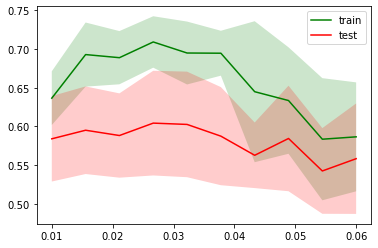

In [32]:
plot_validation_curves(xgb_params_cv[vectorizer_name + 'max_df'], xgb_searcher.cv_results_)

In [14]:
get_scores(xgb_searcher, 'tfidf_maxdf0.03', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
tfidf_maxdf0.03,0.603,0.991,0.498,0.58,0.495,0.5


**accuracy**

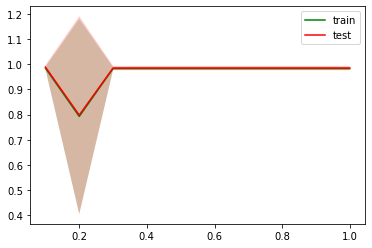

In [63]:
plot_validation_curves(xgb_params_cv[vectorizer_name + 'max_df'], xgb_searcher.cv_results_)

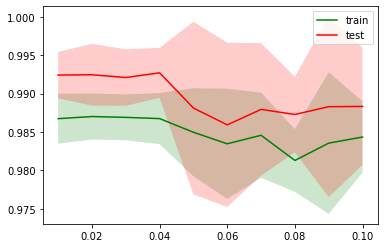

In [35]:
plot_validation_curves(xgb_params_cv[vectorizer_name + 'max_df'], xgb_searcher.cv_results_)

**min_df, ngram_range = (1, 1)**

In [59]:
xgb_params_cv = {vectorizer_name + 'ngram_range': [(1, 1)],
                vectorizer_name + 'min_df': np.logspace(-8, 0, 10)}

In [60]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params_cv, scoring='accuracy', cv=time_split, n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train)

Wall time: 2min 43s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('bag_of_sites',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function create_pipeline.<locals>.<lambda> at 0x0000021DA19411F0>)),
                                                                                        ('vectorizer',
                                                                                         TfidfVectorizer()),
                                                                                        ('feats_counter',
                                                                                         None)])),
                                                                       ('binary_f

**roc_auc**

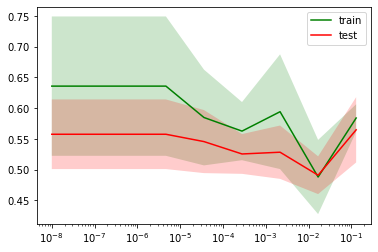

In [41]:
plt.xscale('log')
plot_validation_curves(xgb_params_cv[vectorizer_name + 'min_df'], xgb_searcher.cv_results_)

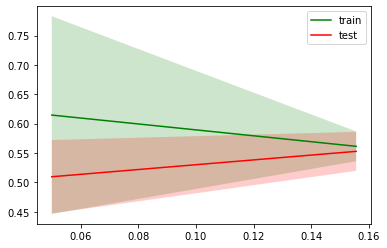

In [44]:
plot_validation_curves(xgb_params_cv[vectorizer_name + 'min_df'], xgb_searcher.cv_results_)

**accuracy**

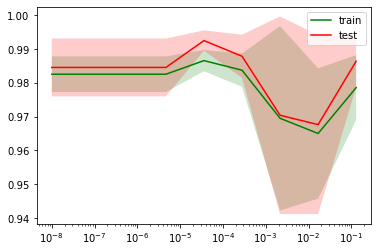

In [61]:
plt.xscale('log')
plot_validation_curves(xgb_params_cv[vectorizer_name + 'min_df'], xgb_searcher.cv_results_)

**min_df, max_df=0.3, ngram_range = (1, 1)**

In [71]:
xgb_params_cv = {vectorizer_name + 'ngram_range': [(1, 1)],
                 vectorizer_name + 'max_df': [0.03],
                vectorizer_name + 'min_df': np.linspace(0.0001, 0.005, 10)}

In [72]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params_cv, scoring='roc_auc', cv=time_split, n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train)

Wall time: 50.5 s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('bag_of_sites',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function create_pipeline.<locals>.<lambda> at 0x0000021DA19411F0>)),
                                                                                        ('vectorizer',
                                                                                         TfidfVectorizer()),
                                                                                        ('feats_counter',
                                                                                         None)])),
                                                                       ('binary_f

**roc_auc**

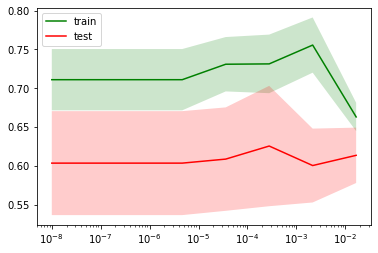

In [67]:
plt.xscale('log')
plot_validation_curves(xgb_params_cv[vectorizer_name + 'min_df'], xgb_searcher.cv_results_)

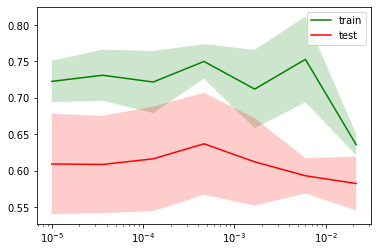

In [70]:
plt.xscale('log')
plot_validation_curves(xgb_params_cv[vectorizer_name + 'min_df'], xgb_searcher.cv_results_)

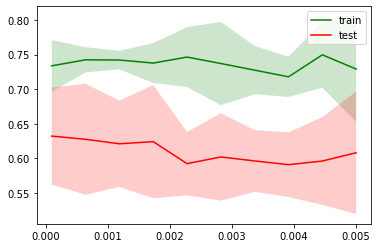

In [73]:
plot_validation_curves(xgb_params_cv[vectorizer_name + 'min_df'], xgb_searcher.cv_results_)

**check on test**

In [78]:
pipeline.fit(X_train, y_train)
get_scores_point(pipeline, 'pipe_xgb_max_df03_min_df0001_ngram1', *data_params)

,cv_accuracy,holdout_accu,f1,roc_auc,precision,recall
pipe_xgb_max_df03_min_df0001_ngram1,0.991,0.991,0.498,0.599,0.495,0.5


In [79]:
pipeline.fit(train_data, y_catch_me)
write_to_submission_file(pipeline.predict_proba(test_data)[:, 1], 'pipe_xgb_max_df03_min_df0001_ngram1.csv')

ничего не улучшилось

**max_features, ngram_range = (1, 1)**

In [20]:
xgb_params_cv = {vectorizer_name + 'ngram_range': [(1, 1)],
                vectorizer_name + 'max_features': np.arange(1000, 10001, 1000)}

In [21]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params_cv, scoring='roc_auc', cv=time_split, n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train)

Wall time: 1min 44s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('bag_of_sites',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function create_pipeline.<locals>.<lambda> at 0x0000021DA0AF6EE0>)),
                                                                                        ('vectorizer',
                                                                                         TfidfVectorizer()),
                                                                                        ('feats_counter',
                                                                                         None)])),
                                                                       ('binary_f

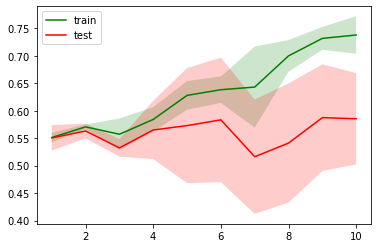

In [13]:
plot_validation_curves(xgb_params_cv[vectorizer_name + 'max_features'], xgb_searcher.cv_results_)

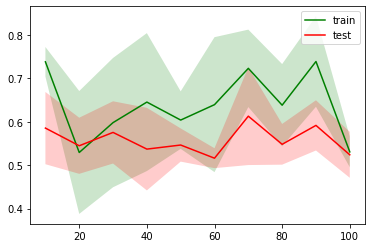

In [16]:
plot_validation_curves(xgb_params_cv[vectorizer_name + 'max_features'], xgb_searcher.cv_results_)

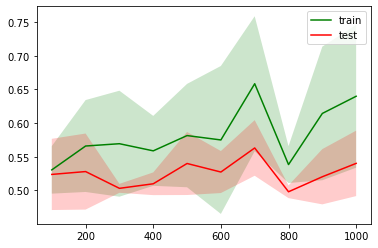

In [19]:
plot_validation_curves(xgb_params_cv[vectorizer_name + 'max_features'], xgb_searcher.cv_results_)

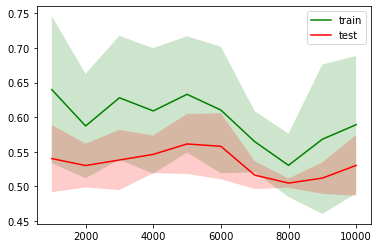

In [22]:
plot_validation_curves(xgb_params_cv[vectorizer_name + 'max_features'], xgb_searcher.cv_results_)

max_features не влияет на скор

**max_df, ngram_range = (1, 2)**

In [9]:
xgb_params_cv = {vectorizer_name + 'ngram_range': [(1, 2)],
                vectorizer_name + 'max_df': np.logspace(-8, 0, 10)}

In [10]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params_cv, scoring='roc_auc', cv=time_split, n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train)

Wall time: 20min 52s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('bag_of_sites',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function create_pipeline.<locals>.<lambda> at 0x000001DBFCDC0670>)),
                                                                                        ('vectorizer',
                                                                                         TfidfVectorizer()),
                                                                                        ('feats_counter',
                                                                                         None)])),
                                                                       ('binary_f

**roc_auc**

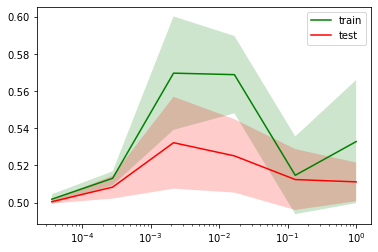

In [11]:
plt.xscale('log')
plot_validation_curves(xgb_params_cv[vectorizer_name + 'max_df'], xgb_searcher.cv_results_)

**min_df, ngram_range = (1, 2)**

In [12]:
xgb_params_cv = {vectorizer_name + 'ngram_range': [(1, 2)],
                vectorizer_name + 'min_df': np.logspace(-8, 0, 10)}

In [13]:
%%time
xgb_searcher = GridSearchCV(pipeline, xgb_params_cv, scoring='roc_auc', cv=time_split, n_jobs=-1, 
                              return_train_score=True)
xgb_searcher.fit(X_train, y_train)

c:\programdata\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Wall time: 14min 58s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             estimator=Pipeline(steps=[('feature_processing',
                                        FeatureUnion(transformer_list=[('bag_of_sites',
                                                                        Pipeline(steps=[('selecting',
                                                                                         FunctionTransformer(func=<function create_pipeline.<locals>.<lambda> at 0x000001DBFCDC0670>)),
                                                                                        ('vectorizer',
                                                                                         TfidfVectorizer()),
                                                                                        ('feats_counter',
                                                                                         None)])),
                                                                       ('binary_f

**roc_auc**

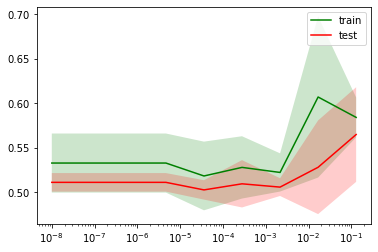

In [14]:
plt.xscale('log')
plot_validation_curves(xgb_params_cv[vectorizer_name + 'min_df'], xgb_searcher.cv_results_)

Получается, что TfIdfVectorizer лучше использовать с дефолтными настройками

## Отбор признаков

In [7]:
xgb = XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', use_label_encoder=False, verbosity=0,
                              **xgb_params)

In [8]:
fselector = FeaturesSelector()

In [13]:
%%time
fselector.fit_transform(xgb, blocks=None, X=X_train, y=y_train, cv=time_split, n=3, continue_last=True)

KeyError: 'day11'

In [12]:
fselector.report

,feature,operation,roc_auc
0,start,start,0.889643
1,day10,delete,0.889724
2,day4,delete,0.886291
3,day10,add,0.889643


In [14]:
fselector.report

,feature,operation,roc_auc
0,start,start,0.889643
1,day10,delete,0.889724
2,day4,delete,0.886291
3,day10,add,0.889643
4,day11,delete,0.895448


In [65]:
pipeline.fit(train_data, y_catch_me)

Pipeline(steps=[('feature_processing',
                 FeatureUnion(transformer_list=[('binary_variables',
                                                 FunctionTransformer(func=<function <lambda> at 0x00000218B8F0EEE0>)),
                                                ('categorical_variables',
                                                 Pipeline(steps=[('selecting',
                                                                  FunctionTransformer(func=<function <lambda> at 0x00000218B8F0EB80>)),
                                                                 ('hot_encoding',
                                                                  OneHotEncoder(handle_unknown='ignore')),
                                                                 ('dim_reducing',
                                                                  Tru...
                               interaction_constraints='', learning_rate=0.4,
                               max_delta_step=0, max_depth=7,


In [66]:
preds = pipeline.predict_proba(test_data)

In [67]:
preds

array([[0.99726367, 0.00273636],
       [0.9980585 , 0.0019415 ],
       [0.99707025, 0.00292973],
       ...,
       [0.99703807, 0.00296196],
       [0.9980585 , 0.0019415 ],
       [0.9962338 , 0.00376615]], dtype=float32)

In [68]:
write_to_submission_file(preds[:, 1], 'xgb_n70_d7_l210_l1260.csv')